# Análisis de Dataset de Clientes

## 1. Instalación de librerías necesarias
Asegúrate de instalar las librerías para poder ejecutar el notebook.

In [ ]:
%pip install --upgrade pip
%pip install -r requirements.txt

## 2. Importación de librerías

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

## 3. Carga del dataset

In [3]:
path = "data/dataset_sintetico_clientes.xlsx"
df = pd.read_excel(path, index_col="cliente_id")
df.head(10)

,frecuencia_compra,monto_total,categoria_producto,edad_cliente,region,dias_desde_ultima_compra,satisfaccion,descuento_aplicado,productos_comprados
cliente_id,,,,,,,,,
1,39,3499.959239,C,18,Sur,5,4,41.491063,3
2,29,4986.414897,D,25,Norte,203,2,32.736267,13
3,15,4488.220802,B,40,Oeste,238,2,20.560203,3
4,43,2901.192168,A,20,Este,184,5,33.168127,6
5,8,4591.108285,C,21,Norte,359,4,5.911121,11
6,21,76.235032,A,42,Norte,291,3,20.074881,17
7,39,4876.582457,C,64,Sur,334,5,39.656427,10
8,19,2479.206457,B,55,Este,219,2,11.025439,12
9,23,3628.335678,C,32,Este,115,4,9.298075,17


### Información del DataFrame

In [4]:
print(f"Información general del dataset:")
print(df.info())

print(f"\nValores duplicados en todo el dataset: {df.duplicated().sum()}")

print(f"\nValores NaN en todo el dataset:\n{df.isna().sum()}")

print(f"\nForma del dataset: {df.shape}")

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 1000
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   frecuencia_compra         1000 non-null   int64  
 1   monto_total               1000 non-null   float64
 2   categoria_producto        1000 non-null   object 
 3   edad_cliente              1000 non-null   int64  
 4   region                    1000 non-null   object 
 5   dias_desde_ultima_compra  1000 non-null   int64  
 6   satisfaccion              1000 non-null   int64  
 7   descuento_aplicado        1000 non-null   float64
 8   productos_comprados       1000 non-null   int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 78.1+ KB
None

Valores duplicados en todo el dataset: 0

Valores NaN en todo el dataset:
frecuencia_compra           0
monto_total                 0
categoria_producto          0
edad_cliente                

### Resumen estadístico con medidas adicionales

In [5]:
complete_statistic_summary = df.describe()
for col in df.columns:
    if df[col].dtype in [np.float64, np.int64]:
        complete_statistic_summary.at['median', col] = df[col].median()
        complete_statistic_summary.at['mode', col] = df[col].mode()[0]
        complete_statistic_summary.at['variance', col] = df[col].var()

complete_statistic_summary.head(12)

,frecuencia_compra,monto_total,edad_cliente,dias_desde_ultima_compra,satisfaccion,descuento_aplicado,productos_comprados
count,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,25.379000,2.575267e+03,43.967000,186.571000,3.002000,24.410256,10.019000
std,14.122138,1.398215e+03,14.822470,103.053253,1.403555,14.297270,5.438034
min,1.000000,5.117574e+01,18.000000,0.000000,1.000000,0.103826,1.000000
25%,13.000000,1.381837e+03,31.000000,97.750000,2.000000,12.003801,6.000000
50%,26.000000,2.656676e+03,44.000000,191.000000,3.000000,24.369769,10.000000
75%,37.000000,3.753561e+03,57.000000,272.000000,4.000000,36.690982,15.000000
max,49.000000,4.996800e+03,69.000000,364.000000,5.000000,49.952475,19.000000
median,26.000000,2.656676e+03,44.000000,191.000000,3.000000,24.369769,10.000000
mode,26.000000,5.117574e+01,58.000000,238.000000,3.000000,0.103826,7.000000


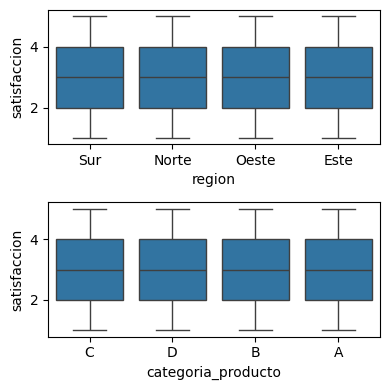

In [6]:
fig, axes = plt.subplots(2,1, figsize=(4,4))
axes = axes.flatten()

sns.boxplot(x="region", y="satisfaccion", data=df, ax=axes[0])
sns.boxplot(x="categoria_producto", y="satisfaccion", data=df, ax=axes[1])

plt.tight_layout()
plt.show()



## 4. Evaluación inicial de las variables numéricas

#### Distribuciones

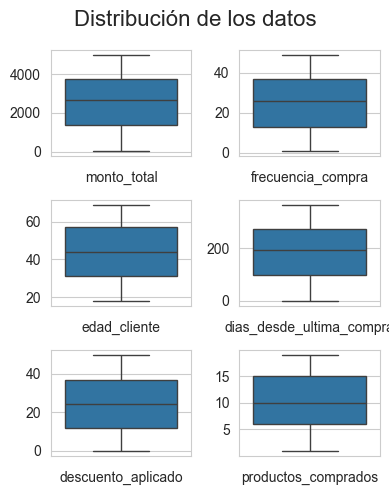

In [7]:
columns = ["monto_total", "frecuencia_compra", "edad_cliente", 
           "dias_desde_ultima_compra", "descuento_aplicado", "productos_comprados"]

sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(4,5))
fig.suptitle("Distribución de los datos", fontsize=16)
axes = axes.flatten()
for i, col in enumerate(columns):
    sns.boxplot(data=df, y=col, ax=axes[i])
    axes[i].set_ylabel("")
    axes[i].set_xlabel(col)
plt.tight_layout()
plt.show()

#### Correlación entre variables

Primero según la satisfacción

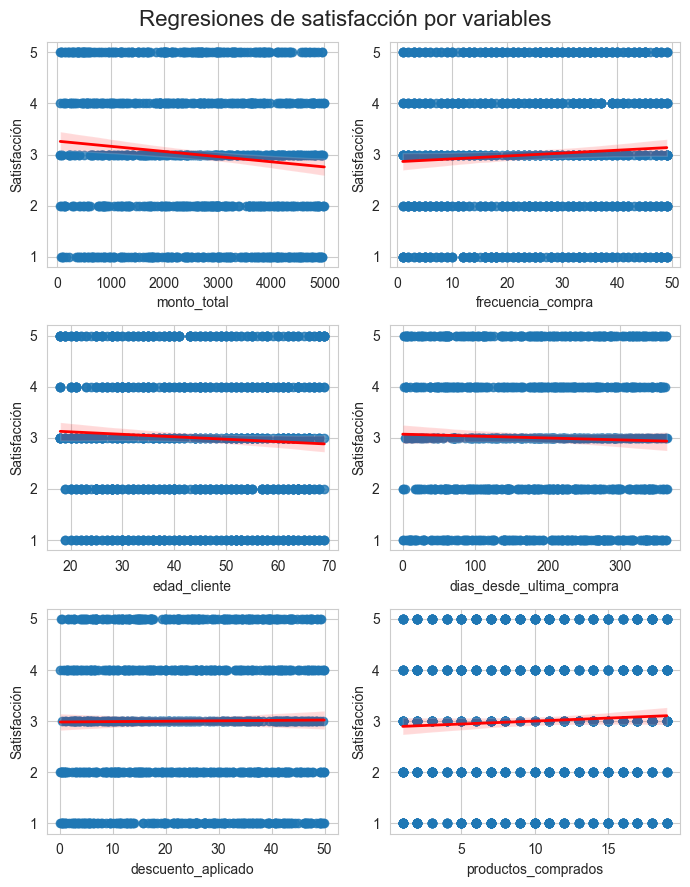

Matriz de coeficientes de correlación:
      variable_analizada  coef_pearson  p_value_pearson  coef_spearman  p_value_spearman
             monto_total     -0.100463         0.001468      -0.100768          0.001419
       frecuencia_compra      0.056826         0.072460       0.056849          0.072350
            edad_cliente     -0.050807         0.108345      -0.049522          0.117575
dias_desde_ultima_compra     -0.027358         0.387468      -0.027578          0.383669
      descuento_aplicado      0.007926         0.802338       0.009494          0.764276
     productos_comprados      0.044848         0.156439       0.045327          0.152052


In [8]:
columns = ["monto_total", "frecuencia_compra", "edad_cliente", 
           "dias_desde_ultima_compra", "descuento_aplicado", "productos_comprados"]

results = []

fig, axes = plt.subplots(3, 2, figsize=(7, 9))
fig.suptitle("Regresiones de satisfacción por variables", fontsize=16)
axes = axes.flatten()

for i, col in enumerate(columns):
    sns.regplot(x=col, y="satisfaccion", data=df, ax=axes[i],
                line_kws={"color": "red", "linewidth": 2})
    
    r_p, p_p = pearsonr(df[col], df["satisfaccion"])
    r_s, p_s = spearmanr(df[col], df["satisfaccion"])

    results.append({
        "variable_analizada": col,
        "coef_pearson": r_p,
        "p_value_pearson": p_p,
        "coef_spearman": r_s,
        "p_value_spearman": p_s
    })

    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Satisfacción")

plt.tight_layout()
plt.show()

corr_satisfaccion = pd.DataFrame(results)
print(f"Matriz de coeficientes de correlación:\n{corr_satisfaccion.to_string(index=False)}")

Después según el monto total

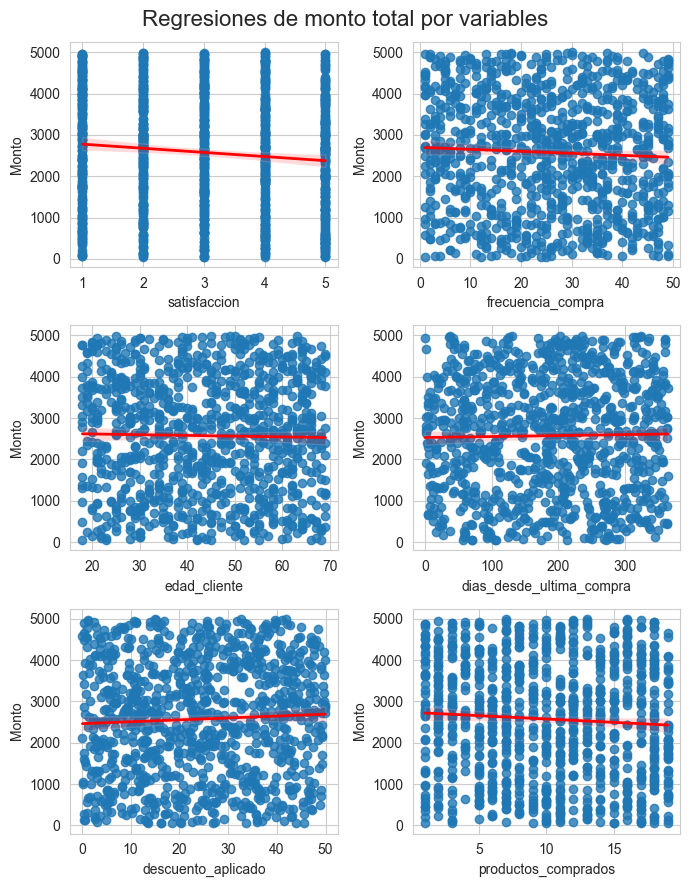

Matriz de coeficientes de correlación:
      variable_analizada  coef_pearson  p_value_pearson  coef_spearman  p_value_spearman
            satisfaccion     -0.100463         0.001468      -0.100768          0.001419
       frecuencia_compra     -0.048946         0.121914      -0.047585          0.132649
            edad_cliente     -0.018836         0.551868      -0.020229          0.522847
dias_desde_ultima_compra      0.017258         0.585692       0.016187          0.609157
      descuento_aplicado      0.047005         0.137442       0.047951          0.129692
     productos_comprados     -0.062968         0.046511      -0.061789          0.050777


In [9]:
columns = ["satisfaccion", "frecuencia_compra", "edad_cliente", 
           "dias_desde_ultima_compra", "descuento_aplicado", "productos_comprados"]

results = []

fig, axes = plt.subplots(3, 2, figsize=(7, 9))
fig.suptitle("Regresiones de monto total por variables", fontsize=16)
axes = axes.flatten()

for i, col in enumerate(columns):
    sns.regplot(x=col, y="monto_total", data=df, ax=axes[i],
                line_kws={"color": "red", "linewidth": 2})
    
    r_p, p_p = pearsonr(df[col], df["monto_total"])
    r_s, p_s = spearmanr(df[col], df["monto_total"])

    results.append({
        "variable_analizada": col,
        "coef_pearson": r_p,
        "p_value_pearson": p_p,
        "coef_spearman": r_s,
        "p_value_spearman": p_s
    })

    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Monto")

plt.tight_layout()
plt.show()

corr_monto = pd.DataFrame(results)
print(f"Matriz de coeficientes de correlación:\n{corr_monto.to_string(index=False)}")

## 5. Feature Engineering: Creación de categorías

In [10]:
df_clean = df.copy()

df_clean["grado_frecuencia"] = pd.qcut(
    df_clean["frecuencia_compra"],
    q=4,
    labels=["muy baja", "baja", "media", "alta"])

df_clean["tipo_gastador"] = pd.qcut(
    df_clean["monto_total"],
    q=4,
    labels=["muy bajo", "bajo", "medio", "alto"])

df_clean["cliente_reciente"] = pd.qcut(
    df_clean["dias_desde_ultima_compra"],
    q=4,
    labels=["muy reciente", "reciente", "medio reciente", "poco reciente"])

df_clean.head(10)

,frecuencia_compra,monto_total,categoria_producto,edad_cliente,region,dias_desde_ultima_compra,satisfaccion,descuento_aplicado,productos_comprados,grado_frecuencia,tipo_gastador,cliente_reciente
cliente_id,,,,,,,,,,,,
1,39,3499.959239,C,18,Sur,5,4,41.491063,3,alta,medio,muy reciente
2,29,4986.414897,D,25,Norte,203,2,32.736267,13,media,alto,medio reciente
3,15,4488.220802,B,40,Oeste,238,2,20.560203,3,baja,alto,medio reciente
4,43,2901.192168,A,20,Este,184,5,33.168127,6,alta,medio,reciente
5,8,4591.108285,C,21,Norte,359,4,5.911121,11,muy baja,alto,poco reciente
6,21,76.235032,A,42,Norte,291,3,20.074881,17,baja,muy bajo,poco reciente
7,39,4876.582457,C,64,Sur,334,5,39.656427,10,alta,alto,poco reciente
8,19,2479.206457,B,55,Este,219,2,11.025439,12,baja,bajo,medio reciente
9,23,3628.335678,C,32,Este,115,4,9.298075,17,baja,medio,reciente


## 6. Agregaciones por segmento

Agrupación de datos usando la media

In [11]:
df_clean.groupby("grado_frecuencia", observed=False).agg({
    "monto_total": "mean",
    "satisfaccion": "mean",
    "descuento_aplicado": "mean"
}).reset_index()

,grado_frecuencia,monto_total,satisfaccion,descuento_aplicado
0,muy baja,2710.939566,2.888889,23.720479
1,baja,2554.712735,2.951673,24.996760
2,media,2437.517061,3.106557,24.361314
3,alta,2596.335098,3.072340,24.529387


In [12]:
df_clean.groupby("tipo_gastador", observed=False).agg({
    "frecuencia_compra": "mean",
    "satisfaccion": "mean",
    "descuento_aplicado": "mean"
}).reset_index()

,tipo_gastador,frecuencia_compra,satisfaccion,descuento_aplicado
0,muy bajo,26.100,3.144,23.462431
1,bajo,25.348,3.068,23.463505
2,medio,25.760,3.012,25.345346
3,alto,24.308,2.784,25.369742


In [13]:
df_clean.groupby("cliente_reciente", observed=False).agg({
    "frecuencia_compra": "mean",
    "satisfaccion": "mean",
    "descuento_aplicado": "mean"
}).reset_index()

,cliente_reciente,frecuencia_compra,satisfaccion,descuento_aplicado
0,muy reciente,24.956000,3.072000,24.496855
1,reciente,25.784314,3.023529,24.513465
2,medio reciente,25.878049,2.939024,25.043347
3,poco reciente,24.895582,2.971888,23.592150


Agrupación de datos usando la suma acumulada

In [14]:
df_sum = df_clean.groupby("grado_frecuencia", observed=False).agg(
    monto_total_sum=("monto_total", "sum"),
    descuento_total_sum=("descuento_aplicado", "sum")
).reset_index()
df_sum

,grado_frecuencia,monto_total_sum,descuento_total_sum
0,muy baja,683156.770597,5977.560780
1,baja,687217.725754,6724.128512
2,media,594754.162812,5944.160666
3,alta,610138.747942,5764.405955


Obtención de valores relevantes para el análisis

In [15]:
monto_muy_baja = df_sum.loc[df_sum["grado_frecuencia"] == "muy baja", "monto_total_sum"].values[0]
monto_alta = df_sum.loc[df_sum["grado_frecuencia"] == "alta", "monto_total_sum"].values[0]
print(f"Diferencia entre el segmento de menor y mayor frecuencia: {monto_alta - monto_muy_baja:.2f}")

Diferencia entre el segmento de menor y mayor frecuencia: -73018.02


## 7. Histogramas de edad y productos comprados

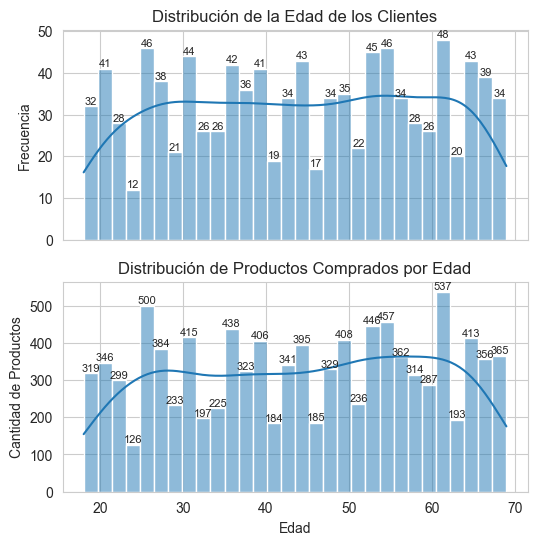

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
sns.histplot(data=df_clean, x='edad_cliente', bins=30, kde=True, edgecolor='white', ax=axes[0])
axes[0].set_title('Distribución de la Edad de los Clientes')
axes[0].set_ylabel('Frecuencia')
axes[0].set_xlabel('')
for p in axes[0].patches:
    h = p.get_height()
    if h > 0:
        axes[0].annotate(f'{int(h)}', (p.get_x() + p.get_width()/2, h), ha='center', va='bottom', fontsize=8)
sns.histplot(data=df_clean, x='edad_cliente', weights='productos_comprados', bins=30, kde=True, edgecolor='white', ax=axes[1])
axes[1].set_title('Distribución de Productos Comprados por Edad')
axes[1].set_ylabel('Cantidad de Productos')
axes[1].set_xlabel('Edad')
for p in axes[1].patches:
    h = p.get_height()
    if h > 0:
        axes[1].annotate(f'{int(h)}', (p.get_x() + p.get_width()/2, h), ha='center', va='bottom', fontsize=8)
plt.show()

## 8. Evaluación de métricas por tipo de cliente

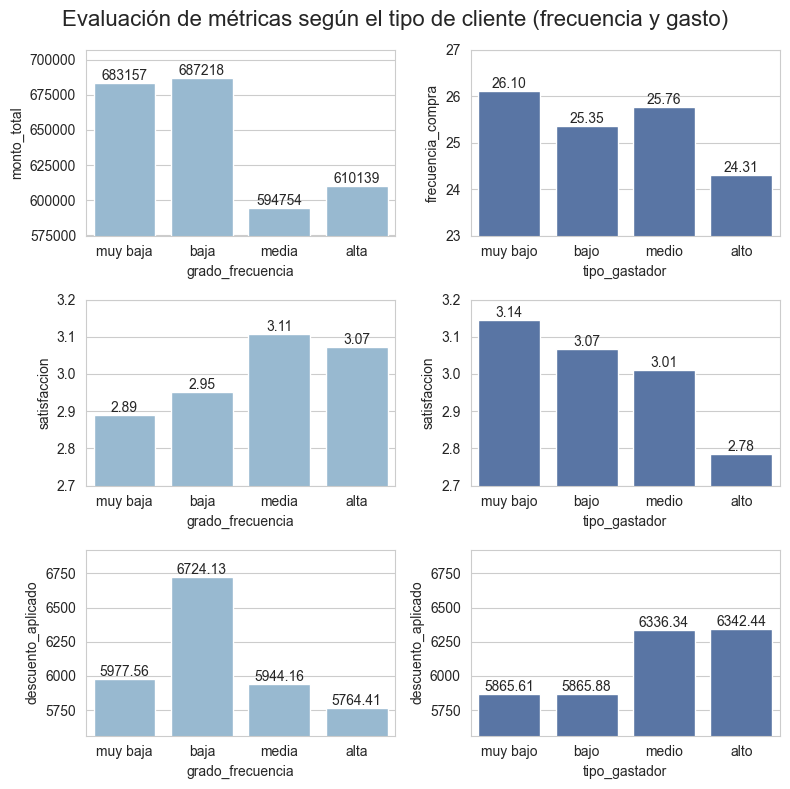

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(8, 8))
axes = axes.flatten()
color_derecha = "#4C72B0"
color_izquierda = "#8FBBD9"
fig.suptitle("Evaluación de métricas según el tipo de cliente (frecuencia y gasto)", fontsize=16)

sns.barplot(data=df_clean, x="grado_frecuencia", y="monto_total", color=color_izquierda, estimator=sum, errorbar=None, ax=axes[0])
axes[0].set_ylim(df_sum["monto_total_sum"].min()-20000, df_sum["monto_total_sum"].max()+20000)
for p in axes[0].patches:
    axes[0].annotate(f"{p.get_height():.0f}",(p.get_x() + p.get_width()/2, p.get_height()), ha="center", va="bottom")

sns.barplot(data=df_clean, x="grado_frecuencia", y="satisfaccion", color=color_izquierda, errorbar=None, ax=axes[2])
axes[2].set_ylim(2.7, 3.2)
for p in axes[2].patches:
    axes[2].annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width()/2, p.get_height()), ha="center", va="bottom")

sns.barplot(data=df_clean, x="grado_frecuencia", y="descuento_aplicado", color=color_izquierda, estimator="sum", errorbar=None, ax=axes[4])
axes[4].set_ylim(df_sum["descuento_total_sum"].min()-200, df_sum["descuento_total_sum"].max()+200)
for p in axes[4].patches:
    axes[4].annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width()/2, p.get_height()), ha="center", va="bottom")

sns.barplot(data=df_clean, x="tipo_gastador", y="frecuencia_compra", color=color_derecha, errorbar=None, ax=axes[1])
axes[1].set_ylim(23, 27)
for p in axes[1].patches:
    axes[1].annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width()/2, p.get_height()), ha="center", va="bottom")

sns.barplot(data=df_clean, x="tipo_gastador", y="satisfaccion", color=color_derecha, errorbar=None, ax=axes[3])
axes[3].set_ylim(2.7, 3.2)
for p in axes[3].patches:
    axes[3].annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width()/2, p.get_height()), ha="center", va="bottom")

sns.barplot(data=df_clean, x="tipo_gastador", y="descuento_aplicado", color=color_derecha, estimator="sum", errorbar=None, ax=axes[5])
axes[5].set_ylim(df_sum["descuento_total_sum"].min()-200, df_sum["descuento_total_sum"].max()+200)
for p in axes[5].patches:
    axes[5].annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width()/2, p.get_height()), ha="center", va="bottom")

plt.tight_layout()
plt.show()

## 9. Información por región y categoría de producto

Agrupación de datos

In [18]:
df_producto = df_clean.groupby("categoria_producto", as_index=False)["monto_total"].sum().sort_values("monto_total", ascending=False)
df_region = df_clean.groupby("region", as_index=False)["monto_total"].sum().sort_values("monto_total", ascending=False)

df_producto["porcentaje"] = df_producto["monto_total"] / df_producto["monto_total"].sum()
df_region["porcentaje"] = df_region["monto_total"] / df_region["monto_total"].sum()

order_producto = df_producto["categoria_producto"]
order_region = df_region["region"]

print(df_producto.to_string(index=False))
print("")
print(df_region.to_string(index=False))

categoria_producto   monto_total  porcentaje
                 D 713069.316544    0.276891
                 A 629336.204422    0.244377
                 C 618330.308379    0.240103
                 B 614531.577760    0.238628

region   monto_total  porcentaje
 Norte 695787.547007    0.270181
  Este 645202.649529    0.250538
   Sur 632741.674628    0.245699
 Oeste 601535.535941    0.233582


Visualizaciones relevantes

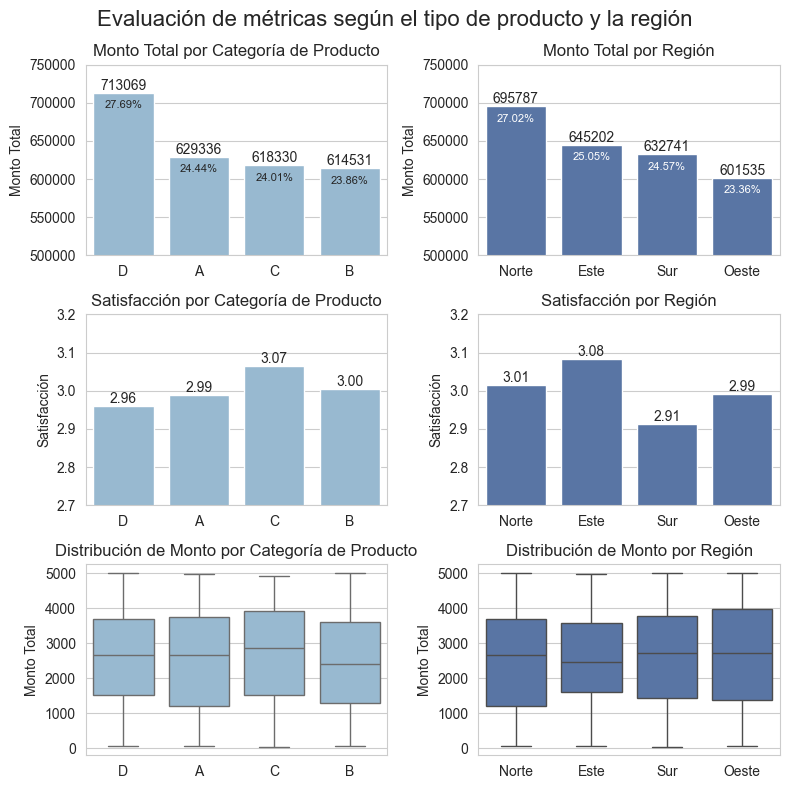

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(8,8))
axes = axes.flatten()

fig.suptitle("Evaluación de métricas según el tipo de producto y la región", fontsize=16)

sns.barplot(data=df_clean, x="categoria_producto", y="monto_total", order=order_producto, estimator="sum", errorbar=None, ax=axes[0], color=color_izquierda)
for p, pct in zip(axes[0].patches, df_producto["porcentaje"]):
    h = p.get_height()
    axes[0].annotate(
        f"{int(h)}",
        (p.get_x() + p.get_width() / 2, h),
        ha='center',
        va='bottom'
    )
    axes[0].annotate(
        f"{pct:.2%}",
        (p.get_x() + p.get_width() / 2, h - 10000),
        ha='center',
        va='top',
        fontsize=8
    )
axes[0].set_title("Monto Total por Categoría de Producto")
axes[0].set_ylabel("Monto Total")
axes[0].set_ylim(500000, 750000)
axes[0].set_xlabel("")

sns.barplot(data=df_clean, x="region", y="monto_total", order=order_region, estimator="sum", errorbar=None, ax=axes[1], color = color_derecha)
for p, pct in zip(axes[1].patches, df_region["porcentaje"]):
    h = p.get_height()
    axes[1].annotate(
        f"{int(h)}",
        (p.get_x() + p.get_width() / 2, h),
        ha='center',
        va='bottom'
    )
    axes[1].annotate(
        f"{pct:.2%}",
        (p.get_x() + p.get_width() / 2, h - 10000),
        ha='center',
        va='top',
        fontsize=8, color="white"
    )
axes[1].set_title("Monto Total por Región")
axes[1].set_ylabel("Monto Total")
axes[1].set_ylim(500000, 750000)
axes[1].set_xlabel("")

sns.barplot(data=df_clean, x="categoria_producto", y="satisfaccion", order=order_producto, estimator="mean", errorbar=None, ax=axes[2], color = color_izquierda)
for p in axes[2].patches:
    h = p.get_height()
    axes[2].annotate(
        f"{h:.2f}",
        (p.get_x() + p.get_width() / 2, h),
        ha='center',
        va='bottom'
    )
axes[2].set_title("Satisfacción por Categoría de Producto")
axes[2].set_ylabel("Satisfacción")
axes[2].set_ylim(2.7, 3.2)
axes[2].set_xlabel("")

sns.barplot(data=df_clean, x="region", y="satisfaccion", order=order_region, estimator="mean", errorbar=None, ax=axes[3], color = color_derecha)
for p in axes[3].patches:
    h = p.get_height()
    axes[3].annotate(
        f"{h:.2f}",
        (p.get_x() + p.get_width() / 2, h),
        ha='center',
        va='bottom'
    )
axes[3].set_title("Satisfacción por Región")
axes[3].set_ylabel("Satisfacción")
axes[3].set_ylim(2.7, 3.2)
axes[3].set_xlabel("")

sns.boxplot(data=df_clean, x="categoria_producto", y="monto_total", ax=axes[4], color = color_izquierda, order=order_producto)
axes[4].set_title("Distribución de Monto por Categoría de Producto")
axes[4].set_xlabel("")
axes[4].set_ylabel("Monto Total")
sns.boxplot(data=df_clean, x="region", y="monto_total", ax=axes[5], color = color_derecha, order=order_region)
axes[5].set_title("Distribución de Monto por Región")
axes[5].set_xlabel("")
axes[5].set_ylabel("Monto Total")

plt.tight_layout()
plt.show()


## 10. Heatmaps de monto y satisfacción

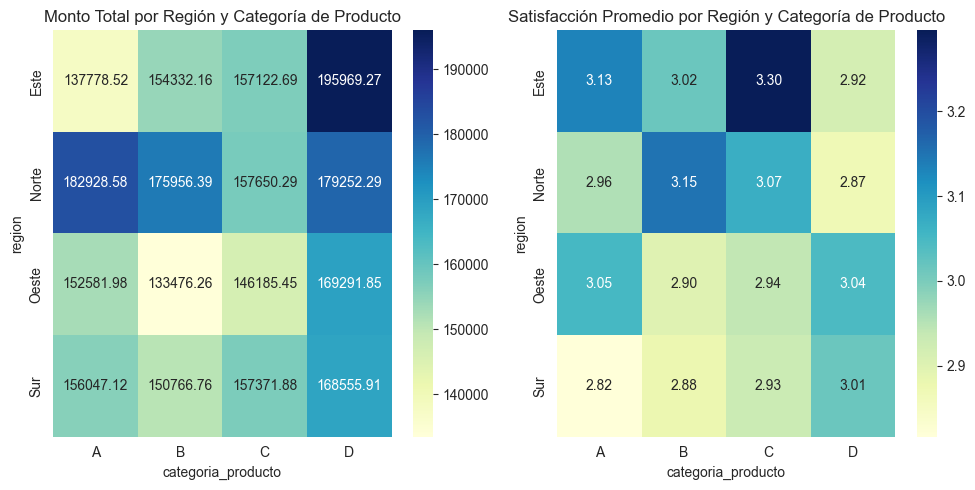

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
pivot_monto = df_clean.pivot_table(values="monto_total", index="region", columns="categoria_producto", aggfunc="sum")
pivot_satisf = df_clean.pivot_table(values="satisfaccion", index="region", columns="categoria_producto", aggfunc="mean")

sns.heatmap(pivot_monto, annot=True, fmt=".2f", cmap="YlGnBu", ax=axes[0])
axes[0].set_title("Monto Total por Región y Categoría de Producto")

sns.heatmap(pivot_satisf, annot=True, fmt=".2f", cmap="YlGnBu", ax=axes[1])
axes[1].set_title("Satisfacción Promedio por Región y Categoría de Producto")

plt.tight_layout()
plt.show()

### Monto acumulado por región y producto

In [21]:
df_sum = df_clean.groupby(["region", "categoria_producto"])["monto_total"].sum().reset_index()

monto_max = df_sum["monto_total"].max()
monto_min = df_sum["monto_total"].min()

region_min = df_sum.loc[df_sum["monto_total"] == monto_min, "region"].values[0]
producto_min = df_sum.loc[df_sum["monto_total"] == monto_min, "categoria_producto"].values[0]

region_max = df_sum.loc[df_sum["monto_total"] == monto_max, "region"].values[0]
producto_max = df_sum.loc[df_sum["monto_total"] == monto_max, "categoria_producto"].values[0]

print("Monto acumulado por región y producto:")
print(df_sum.sort_values(by="monto_total", ascending=False))
print(f"\nGasto mínimo acumulado: {monto_min:.2f} -> Región: {region_min}, Producto: {producto_min}")
print(f"Gasto máximo acumulado: {monto_max:.2f} -> Región: {region_max}, Producto: {producto_max}")
print(f"\nDiferencia entre máximo y mínimo acumulado: {monto_max - monto_min:.2f}")

Monto acumulado por región y producto:
   region categoria_producto    monto_total
3    Este                  D  195969.268449
4   Norte                  A  182928.577121
7   Norte                  D  179252.292636
5   Norte                  B  175956.388129
11  Oeste                  D  169291.846066
15    Sur                  D  168555.909394
6   Norte                  C  157650.289122
14    Sur                  C  157371.880405
2    Este                  C  157122.693270
12    Sur                  A  156047.122398
1    Este                  B  154332.164658
8   Oeste                  A  152581.981751
13    Sur                  B  150766.762430
10  Oeste                  C  146185.445581
0    Este                  A  137778.523152
9   Oeste                  B  133476.262543

Gasto mínimo acumulado: 133476.26 -> Región: Oeste, Producto: B
Gasto máximo acumulado: 195969.27 -> Región: Este, Producto: D

Diferencia entre máximo y mínimo acumulado: 62493.01


### Satisfacción por región y producto

In [22]:
df_satisfaccion = df_clean.groupby(["region", "categoria_producto"])["satisfaccion"].mean().reset_index()

satisfaccion_max = df_satisfaccion["satisfaccion"].max()
satisfaccion_min = df_satisfaccion["satisfaccion"].min()

region_min = df_satisfaccion.loc[df_satisfaccion["satisfaccion"] == satisfaccion_min, "region"].values[0]
region_max = df_satisfaccion.loc[df_satisfaccion["satisfaccion"] == satisfaccion_max, "region"].values[0]

producto_min = df_satisfaccion.loc[df_satisfaccion["satisfaccion"] == satisfaccion_min, "categoria_producto"].values[0]
producto_max = df_satisfaccion.loc[df_satisfaccion["satisfaccion"] == satisfaccion_max, "categoria_producto"].values[0]

print("Satisfacción media por region y producto")
print(df_satisfaccion.sort_values("satisfaccion", ascending=False))

print(f"\nSatisfacción mínima: {satisfaccion_min:.2f} -> Región: {region_min}, Producto: {producto_min}")
print(f"Satisfacción máxima: {satisfaccion_max:.2f} -> Región: {region_max}, Producto: {producto_max}")
print(f"\nDiferencia entre máximo y mínimo: {satisfaccion_max - satisfaccion_min:.2f}")

Satisfacción media por region y producto
   region categoria_producto  satisfaccion
2    Este                  C      3.295082
5   Norte                  B      3.150000
0    Este                  A      3.131148
6   Norte                  C      3.067797
8   Oeste                  A      3.051724
11  Oeste                  D      3.044776
1    Este                  B      3.016129
15    Sur                  D      3.014925
4   Norte                  A      2.955882
10  Oeste                  C      2.941176
14    Sur                  C      2.929825
3    Este                  D      2.916667
9   Oeste                  B      2.900000
13    Sur                  B      2.879310
7   Norte                  D      2.869565
12    Sur                  A      2.816667

Satisfacción mínima: 2.82 -> Región: Sur, Producto: A
Satisfacción máxima: 3.30 -> Región: Este, Producto: C

Diferencia entre máximo y mínimo: 0.48
